# Assignment 9: GBDT

#### Response Coding: Example

In [207]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [212]:
import pandas
import warnings
warnings.filterwarnings('ignore')
data = pandas.read_csv('preprocessed_data.csv',nrows=35000)

In [213]:
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [214]:
data['project_is_approved'].value_counts()

1    29629
0     5371
Name: project_is_approved, dtype: int64

## 1. calculate sentiment scores for the essay feature

In [215]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
sid = SentimentIntensityAnalyzer()

neg=[]
pos=[]
neu=[]
compound=[]

for i in tqdm(data['essay'].values):
    ss=sid.polarity_scores(i)
    neg.append(ss['neg'])
    pos.append(ss['pos'])
    neu.append(ss['neu'])
    compound.append(ss['compound'])

100%|███████████████████████████████████████████████████████████████████████████| 35000/35000 [02:43<00:00, 214.05it/s]


In [216]:
data['negative_sentiment_value']=neg
data['positive_sentiment_value']=pos
data['neutral_sentiment_value']=neu
data['compound_sentiment_value']=compound

data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,negative_sentiment_value,positive_sentiment_value,neutral_sentiment_value,compound_sentiment_value
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,0.017,0.262,0.721,0.9860
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,0.030,0.187,0.783,0.9524
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,0.029,0.288,0.683,0.9873


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [217]:
Y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative_sentiment_value,positive_sentiment_value,neutral_sentiment_value,compound_sentiment_value
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


In [218]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify=Y,random_state=0)
#X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train,random_state=0)

In [219]:
print(X_train.shape, Y_train.shape)
#print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(23450, 12) (23450,)
(11550, 12) (11550,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

## 3. perform tfidf vectorization of text data.

In [220]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit happens only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
#X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After TF-IDF vectorizations")
print(X_train_essay_tfidf.shape, Y_train.shape)
#print(X_cv_essay_tfidf.shape, Y_cv.shape)
print(X_test_essay_tfidf.shape, Y_test.shape)
print("="*100)

After TF-IDF vectorizations
(23450, 5000) (23450,)
(11550, 5000) (11550,)


In [221]:
tfidf_essay_features = vectorizer.get_feature_names()
print(len(tfidf_essay_features))

5000


## 4. perform tfidf w2v vectorization of text data.

In [222]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [223]:
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())
print(len(dictionary),len(tfidf_words))

5000 5000


In [224]:
from tqdm import tqdm
import numpy as np
def own_transform(preprocessed_essays):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return tfidf_w2v_vectors

In [225]:
X_train_essay_tfidf_w2v = own_transform(X_train['essay'].values)
#X_cv_essay_tfidf_w2v = own_transform(X_cv['essay'].values)
X_test_essay_tfidf_w2v = own_transform(X_test['essay'].values)

100%|███████████████████████████████████████████████████████████████████████████| 23450/23450 [01:51<00:00, 210.88it/s]


23450
300


100%|███████████████████████████████████████████████████████████████████████████| 11550/11550 [00:57<00:00, 199.92it/s]

11550
300


### Have not done tf-idf and tf-idf on title since it was not present in preprocessed.csv

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

## 5. perform encoding of categorical features.

In [226]:
def calculateResponseEncoding(data,column):
    uniquevalues=data[column].unique()
    #print(len(uniquevalues))
    
    noOfPostive=[]
    for i in uniquevalues:
        location=data.loc[(data[column]==i)& Y_train==1]
        noOfPostive.append(len(location))
    #print(noOfPostive[1])
    
    noOfNegative=[]
    for i in uniquevalues:
        location=data.loc[(data[column]==i)& Y_train==0]
        noOfNegative.append(len(location))
    #print(noOfNegative[1])
    #print(data.shape)
    # response_coding_positive=positive/(positive+negative)
    prob_pos={}
    for i in range(len(uniquevalues)):
        value=noOfPostive[i]/(noOfPostive[i]+noOfNegative[i])
        prob_pos[uniquevalues[i]]=value
    #print(prob_pos)    
        
    prob_neg={}
    for i in range(len(uniquevalues)):
        value=noOfNegative[i]/(noOfPostive[i]+noOfNegative[i])
        prob_neg[uniquevalues[i]]=value
    #print(prob_neg)
    return prob_pos,prob_neg
        

## 5.1 Response Encoding on school state(Vectorization)

In [227]:
school_state_1_train=calculateResponseEncoding(X_train,'school_state')[0]
school_state_0_train=calculateResponseEncoding(X_train,'school_state')[1]

In [228]:
school_state_neg_train=[]
school_state_pos_train=[]
for i in X_train['school_state']:
    school_state_neg_train.append(school_state_0_train[i])
    school_state_pos_train.append(school_state_1_train[i])
X_train['school_state_0']=school_state_neg_train
X_train['school_state_1']=school_state_pos_train

In [229]:
school_state_neg_test=[]
school_state_pos_test=[]
for i in X_test['school_state']:
    #print(school_state_0_train.get(i))
    if school_state_0_train.get(i)==None:
        school_state_neg_test.append(1/2)
    else:
        school_state_neg_test.append(school_state_0_train[i])
   
    if school_state_1_train.get(i)==None:
        school_state_pos_test.append(1/2)
    else:
        school_state_pos_test.append(school_state_1_train[i])
        
    #school_state_neg_test.append(school_state_0_test[i])
    #school_state_pos_test.append(school_state_1_test[i])
X_test['school_state_0']=school_state_neg_test
X_test['school_state_1']=school_state_pos_test

## 5.2 Response Encoding on teacher prefix(Vectorization)

In [230]:
teaPrefix_1_train=calculateResponseEncoding(X_train,'teacher_prefix')[0]
teaPrefix_0_train=calculateResponseEncoding(X_train,'teacher_prefix')[1]

In [231]:
teaPrefix_neg_train=[]
teaPrefix_pos_train=[]
for i in X_train['teacher_prefix']:
    teaPrefix_neg_train.append(teaPrefix_0_train[i])
    teaPrefix_pos_train.append(teaPrefix_1_train[i])
X_train['teacherPrefix_0']=teaPrefix_neg_train
X_train['teacherPrefix_1']=teaPrefix_pos_train

In [232]:
teaPrefix_neg_test=[]
teaPrefix_pos_test=[]
for i in X_test['teacher_prefix']:
    if teaPrefix_1_train.get(i)==None:
        teaPrefix_pos_test.append(1/2)
    else:
        teaPrefix_pos_test.append(teaPrefix_1_train[i])
    
    if teaPrefix_0_train.get(i)==None:
        teaPrefix_neg_test.append(1/2)
    else:
        teaPrefix_neg_test.append(teaPrefix_0_train[i])
    #teaPrefix_neg_train.append(teaPrefix_0_train[i])
    #teaPrefix_pos_train.append(teaPrefix_1_train[i])
X_test['teacherPrefix_0']=teaPrefix_neg_test
X_test['teacherPrefix_1']=teaPrefix_pos_test

## 5.3 Response Encoding on project grade category(Vectorization)

In [233]:
proGrade_1_train=calculateResponseEncoding(X_train,'project_grade_category')[0]
proGrade_0_train=calculateResponseEncoding(X_train,'project_grade_category')[1]

In [234]:
proGrade_neg_train=[]
proGrade_pos_train=[]
for i in X_train['project_grade_category']:
    proGrade_neg_train.append(proGrade_0_train[i])
    proGrade_pos_train.append(proGrade_1_train[i])
X_train['projectGrade_0']=proGrade_neg_train
X_train['projectGrade_1']=proGrade_pos_train

In [235]:
proGrade_neg_test=[]
proGrade_pos_test=[]
for i in X_test['project_grade_category']:
    if proGrade_0_train.get(i)==None:
        proGrade_neg_test.append(1/2)
    else:
        proGrade_neg_test.append(proGrade_0_train[i])
    
    if proGrade_1_train.get(i)==None:
        proGrade_pos_test.append(1/2)
    else:
        proGrade_pos_test.append(proGrade_1_train[i])
    #proGrade_neg_train.append(proGrade_0_train[i])
    #proGrade_pos_train.append(proGrade_1_train[i])
X_test['projectGrade_0']=proGrade_neg_test
X_test['projectGrade_1']=proGrade_pos_test

## 5.4 Response Encoding on clean categories(Vectorization)

In [236]:
clean_categories_1_train=calculateResponseEncoding(X_train,'clean_categories')[0]
clean_categories_0_train=calculateResponseEncoding(X_train,'clean_categories')[1]

In [237]:
clean_categories_neg_train=[]
clean_categories_pos_train=[]
for i in X_train['clean_categories']:
    clean_categories_neg_train.append(clean_categories_0_train[i])
    clean_categories_pos_train.append(clean_categories_1_train[i])
X_train['clean_categories_0']=clean_categories_neg_train
X_train['clean_categories_1']=clean_categories_pos_train

In [238]:
clean_categories_neg_test=[]
clean_categories_pos_test=[]
for i in X_test['clean_categories']:
    if clean_categories_0_train.get(i)==None:
        clean_categories_neg_test.append(1/2)
    else:
        clean_categories_neg_test.append(clean_categories_0_train[i])
        
    if clean_categories_1_train.get(i)==None:
        clean_categories_pos_test.append(1/2)
    else:
        clean_categories_pos_test.append(clean_categories_1_train[i])
        
    #clean_categories_neg_train.append(clean_categories_0_train[i])
    #clean_categories_pos_train.append(clean_categories_1_train[i])
X_test['clean_categories_0']=clean_categories_neg_test
X_test['clean_categories_1']=clean_categories_pos_test

## 5.5 Response Encoding on clean sub-categories(Vectorization)

In [239]:
clean_subcategories_1_train=calculateResponseEncoding(X_train,'clean_subcategories')[0]
clean_subcategories_0_train=calculateResponseEncoding(X_train,'clean_subcategories')[1]

In [240]:
clean_subcategories_neg_train=[]
clean_subcategories_pos_train=[]
for i in X_train['clean_subcategories']:
    clean_subcategories_neg_train.append(clean_subcategories_0_train[i])
    clean_subcategories_pos_train.append(clean_subcategories_1_train[i])
X_train['clean_subcategories_0']=clean_subcategories_neg_train
X_train['clean_subcategories_1']=clean_subcategories_pos_train

In [241]:
clean_subcategories_neg_test=[]
clean_subcategories_pos_test=[]
for i in X_test['clean_subcategories']:
    if clean_subcategories_0_train.get(i)==None:
        clean_subcategories_neg_test.append(1/2)
    else:
        clean_subcategories_neg_test.append(clean_subcategories_0_train[i])
        
    if clean_subcategories_1_train.get(i)==None:
        clean_subcategories_pos_test.append(1/2)
    else:
        clean_subcategories_pos_test.append(clean_subcategories_1_train[i])
        
    #clean_subcategories_neg_train.append(clean_subcategories_0_train[i])
    #clean_subcategories_pos_train.append(clean_subcategories_1_train[i])
X_test['clean_subcategories_0']=clean_subcategories_neg_test
X_test['clean_subcategories_1']=clean_subcategories_pos_test

In [242]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative_sentiment_value,positive_sentiment_value,...,school_state_0,school_state_1,teacherPrefix_0,teacherPrefix_1,projectGrade_0,projectGrade_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
28546,nc,mrs,grades_6_8,8,specialneeds,specialneeds,i work great crowd energetic curious students ...,151.28,0.030,0.278,...,0.954158,0.045842,0.538806,0.461194,0.880426,0.119574,0.973902,0.026098,0.973902,0.026098
7458,ny,ms,grades_3_5,3,literacy_language,literature_writing,a typical day classroom consists twelve differ...,78.10,0.032,0.173,...,0.946311,0.053689,0.702516,0.297484,0.708870,0.291130,0.816290,0.183710,0.965245,0.034755


In [243]:
X_test.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative_sentiment_value,positive_sentiment_value,...,school_state_0,school_state_1,teacherPrefix_0,teacherPrefix_1,projectGrade_0,projectGrade_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
4418,ne,mrs,grades_3_5,0,specialneeds,specialneeds,we title i school enrollment nearly 400 studen...,341.81,0.04,0.180,...,0.997399,0.002601,0.538806,0.461194,0.708870,0.291130,0.973902,0.026098,0.973902,0.026098
34686,fl,ms,grades_6_8,8,health_sports,health_wellness,this project directly inspired wonderful stude...,101.95,0.00,0.322,...,0.949296,0.050704,0.702516,0.297484,0.880426,0.119574,0.867761,0.132239,0.947377,0.052623


## 6.1 Encoding Numericals Feature:Price

In [244]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
#print(X_cv_price_norm.shape, Y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## 6.2 Encoding Numericals Feature:teacher_number_of_previously_posted_projects

In [245]:
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacher_number_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_teacher_number_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_teacher_number_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: school_state_0

In [246]:
normalizer = Normalizer()

normalizer.fit(X_train['school_state_0'].values.reshape(-1,1))

X_train_school_state_0_norm = normalizer.transform(X_train['school_state_0'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_school_state_0_norm = normalizer.transform(X_test['school_state_0'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_school_state_0_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_school_state_0_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: school_state_1

In [247]:
normalizer = Normalizer()

normalizer.fit(X_train['school_state_1'].values.reshape(-1,1))

X_train_school_state_1_norm = normalizer.transform(X_train['school_state_1'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_school_state_1_norm = normalizer.transform(X_test['school_state_1'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_school_state_1_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_school_state_1_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: teacherPrefix_0

In [248]:
normalizer = Normalizer()

normalizer.fit(X_train['teacherPrefix_0'].values.reshape(-1,1))

X_train_teacherPrefix_0_norm = normalizer.transform(X_train['teacherPrefix_0'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacherPrefix_0_norm = normalizer.transform(X_test['teacherPrefix_0'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_teacherPrefix_0_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_teacherPrefix_0_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: teacherPrefix_1

In [249]:
normalizer = Normalizer()

normalizer.fit(X_train['teacherPrefix_1'].values.reshape(-1,1))

X_train_teacherPrefix_1_norm = normalizer.transform(X_train['teacherPrefix_1'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacherPrefix_1_norm = normalizer.transform(X_test['teacherPrefix_1'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_teacherPrefix_1_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_teacherPrefix_1_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: projectGrade_0

In [250]:
normalizer = Normalizer()

normalizer.fit(X_train['projectGrade_0'].values.reshape(-1,1))

X_train_projectGrade_0_norm = normalizer.transform(X_train['projectGrade_0'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projectGrade_0_norm = normalizer.transform(X_test['projectGrade_0'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_projectGrade_0_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_projectGrade_0_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: projectGrade_1

In [251]:
normalizer = Normalizer()

normalizer.fit(X_train['projectGrade_1'].values.reshape(-1,1))

X_train_projectGrade_1_norm = normalizer.transform(X_train['projectGrade_1'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projectGrade_1_norm = normalizer.transform(X_test['projectGrade_1'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_projectGrade_1_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_projectGrade_1_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: clean_categories_0

In [252]:
normalizer = Normalizer()

normalizer.fit(X_train['clean_categories_0'].values.reshape(-1,1))

X_train_clean_categories_0_norm = normalizer.transform(X_train['clean_categories_0'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_clean_categories_0_norm = normalizer.transform(X_test['clean_categories_0'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_clean_categories_0_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_clean_categories_0_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: clean_categories_1

In [253]:
normalizer = Normalizer()

normalizer.fit(X_train['clean_categories_1'].values.reshape(-1,1))

X_train_clean_categories_1_norm = normalizer.transform(X_train['clean_categories_1'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_clean_categories_1_norm = normalizer.transform(X_test['clean_categories_1'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_clean_categories_1_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_clean_categories_1_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: clean_subcategories_0

In [254]:
normalizer = Normalizer()

normalizer.fit(X_train['clean_subcategories_0'].values.reshape(-1,1))

X_train_clean_subcategories_0_norm = normalizer.transform(X_train['clean_subcategories_0'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_clean_subcategories_0_norm = normalizer.transform(X_test['clean_subcategories_0'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_clean_subcategories_0_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_clean_subcategories_0_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: clean_subcategories_1

In [255]:
normalizer = Normalizer()

normalizer.fit(X_train['clean_subcategories_1'].values.reshape(-1,1))

X_train_clean_subcategories_1_norm = normalizer.transform(X_train['clean_subcategories_1'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_clean_subcategories_1_norm = normalizer.transform(X_test['clean_subcategories_1'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_clean_subcategories_1_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_clean_subcategories_1_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: negative_sentiment_value

In [256]:
normalizer = Normalizer()

normalizer.fit(X_train['negative_sentiment_value'].values.reshape(-1,1))

X_train_negative_sentiment_value_norm = normalizer.transform(X_train['negative_sentiment_value'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_negative_sentiment_value_norm = normalizer.transform(X_test['negative_sentiment_value'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_negative_sentiment_value_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_negative_sentiment_value_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: positive_sentiment_value

In [257]:
normalizer = Normalizer()

normalizer.fit(X_train['positive_sentiment_value'].values.reshape(-1,1))

X_train_positive_sentiment_value_norm = normalizer.transform(X_train['positive_sentiment_value'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_positive_sentiment_value_norm = normalizer.transform(X_test['positive_sentiment_value'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_positive_sentiment_value_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_positive_sentiment_value_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: neutral_sentiment_value

In [258]:
normalizer = Normalizer()

normalizer.fit(X_train['neutral_sentiment_value'].values.reshape(-1,1))

X_train_neutral_sentiment_value_norm = normalizer.transform(X_train['neutral_sentiment_value'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_neutral_sentiment_value_norm = normalizer.transform(X_test['neutral_sentiment_value'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_neutral_sentiment_value_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_neutral_sentiment_value_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


## Encoding Numerical Feature: compound_sentiment_value

In [259]:
normalizer = Normalizer()

normalizer.fit(X_train['compound_sentiment_value'].values.reshape(-1,1))

X_train_compound_sentiment_value_norm = normalizer.transform(X_train['compound_sentiment_value'].values.reshape(-1,1))
#X_cv_teacher_number_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_compound_sentiment_value_norm = normalizer.transform(X_test['compound_sentiment_value'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_compound_sentiment_value_norm.shape, Y_train.shape)
#print(X_cv_teacher_number_norm.shape, Y_cv.shape)
print(X_test_compound_sentiment_value_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


In [260]:
X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'negative_sentiment_value',
       'positive_sentiment_value', 'neutral_sentiment_value',
       'compound_sentiment_value', 'school_state_0', 'school_state_1',
       'teacherPrefix_0', 'teacherPrefix_1', 'projectGrade_0',
       'projectGrade_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')

In [261]:
X_test.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'negative_sentiment_value',
       'positive_sentiment_value', 'neutral_sentiment_value',
       'compound_sentiment_value', 'school_state_0', 'school_state_1',
       'teacherPrefix_0', 'teacherPrefix_1', 'projectGrade_0',
       'projectGrade_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')

## 7. For set 1 stack up all the features

In [262]:
print(X_train_essay_tfidf.shape)

(23450, 5000)


In [263]:
from scipy.sparse import hstack

X_train_tfidf = hstack((X_train_essay_tfidf, X_train_school_state_0_norm,X_train_school_state_1_norm, X_train_teacherPrefix_0_norm, X_train_teacherPrefix_1_norm, X_train_projectGrade_0_norm, X_train_projectGrade_1_norm, X_train_clean_categories_0_norm,X_train_clean_categories_1_norm, X_train_clean_subcategories_0_norm, X_train_clean_subcategories_1_norm	,X_train_price_norm,X_train_teacher_number_norm, X_train_negative_sentiment_value_norm, X_train_positive_sentiment_value_norm, X_train_neutral_sentiment_value_norm, X_train_compound_sentiment_value_norm)).tocsr()

X_test_tfidf = hstack((X_test_essay_tfidf, X_test_school_state_0_norm,X_test_school_state_1_norm, X_test_teacherPrefix_0_norm, X_test_teacherPrefix_1_norm, X_test_projectGrade_0_norm, X_test_projectGrade_1_norm, X_test_clean_categories_0_norm,X_test_clean_categories_1_norm, X_test_clean_subcategories_0_norm, X_test_clean_subcategories_1_norm	,X_test_price_norm,X_test_teacher_number_norm, X_test_negative_sentiment_value_norm, X_test_positive_sentiment_value_norm, X_test_neutral_sentiment_value_norm, X_test_compound_sentiment_value_norm)).tocsr()
print("Final Data matrix")
print(X_train_tfidf.shape, Y_train.shape)
#print(X_cv_tfidf.shape, Y_cv.shape)
print(X_test_tfidf.shape, Y_test.shape)
print("="*100)

Final Data matrix
(23450, 5016) (23450,)
(11550, 5016) (11550,)


<h2> Appling Models on different kind of featurization as mentioned in the instructions</h2>

# Set 1 Tf-idf

## Hyper Parameter Tuning

In [264]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params={'max_depth' : [1, 3, 10, 30], 'min_samples_split' : [5, 10, 100, 500]}
classifier_RF=RandomForestClassifier(random_state=0)
classifier=GridSearchCV(classifier_RF,params,cv=3,scoring='roc_auc')
classifier.fit(X_train_tfidf,Y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             scoring='roc_auc')

## Plotting Heatmap

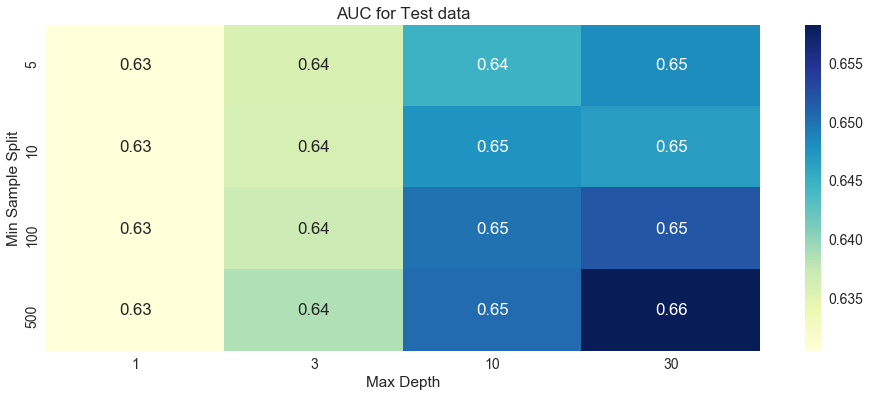

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

max_depth_list = list(classifier.cv_results_['param_max_depth'].data)
min_samples_list = list(classifier.cv_results_['param_min_samples_split'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(16,6))

data = pd.DataFrame(data={'Min Sample Split':min_samples_list, 'Max Depth':max_depth_list, 'AUC':classifier.cv_results_['mean_test_score']})
data = data.pivot(index='Min Sample Split', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Test data')
plt.show()

## Find the best parameters and fit the model.

In [266]:
best_min_samples_split = classifier.best_params_['min_samples_split']
best_max_depth_value = classifier.best_params_['max_depth']
best_score = classifier.best_score_

print("Value of best Min Samples are:",best_min_samples_split)
print("Value of best Max depth is:",best_max_depth_value)
print("Best Score is:",best_score)

Value of best Min Samples are: 500
Value of best Max depth is: 30
Best Score is: 0.6582671929645669


In [267]:
from sklearn.metrics import roc_curve, roc_auc_score

model = RandomForestClassifier(max_depth=best_max_depth_value, min_samples_split=best_min_samples_split,class_weight='balanced',random_state=0)
model.fit(X_train_tfidf,Y_train) 
# Used for task2 i.e. selecting k top features
best_features_index_tfidf=model.feature_importances_.argsort()[::-1]

## Plotting ROC-AUC curve

Training AUC Score: 0.9113114290796807
Test AUC Score: 0.7008762992150342


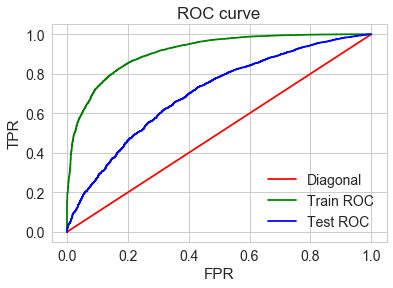

In [268]:
train_predictions = model.predict_proba(X_train_tfidf)
print("Training AUC Score:",roc_auc_score(Y_train, train_predictions[:,1]))

test_predictions = model.predict_proba(X_test_tfidf)
print("Test AUC Score:",roc_auc_score(Y_test, test_predictions[:,1]))

fpr_train, tpr_train, train_threshold = roc_curve(Y_train, train_predictions[:,1])
fpr_test, tpr_test, test_threshold = roc_curve(Y_test, test_predictions[:,1])

plt.plot([0,1],[0,1],'r',label="Diagonal")
plt.plot(fpr_train, tpr_train,'g',label="Train ROC")
plt.plot(fpr_test, tpr_test,'b',label="Test ROC")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')
plt.show()

## Observations->
Training AUC Score: 0.9113114290796807 and Test AUC Score: 0.7008762992150342. By this we can conclude that most probably our model is overfitting o the best values which are found by Grid Search

## 11. Plotting Confusion Matrix

In [269]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

Confusion matrix


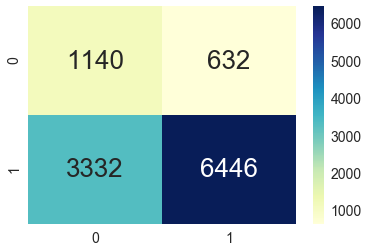

In [270]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix")
conf_matr_df_train = pd.DataFrame(confusion_matrix(Y_test, predict(test_predictions[:,1], test_threshold, fpr_test, tpr_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

# Set-2 Tf-idf w2v

In [271]:
from scipy.sparse import hstack

X_train_tfidf_w2v = np.hstack((X_train_essay_tfidf_w2v,X_train_school_state_0_norm,X_train_school_state_1_norm, X_train_teacherPrefix_0_norm, X_train_teacherPrefix_1_norm, X_train_projectGrade_0_norm, X_train_projectGrade_1_norm, X_train_clean_categories_0_norm,X_train_clean_categories_1_norm, X_train_clean_subcategories_0_norm, X_train_clean_subcategories_1_norm	,X_train_price_norm,X_train_teacher_number_norm, X_train_negative_sentiment_value_norm, X_train_positive_sentiment_value_norm, X_train_neutral_sentiment_value_norm, X_train_compound_sentiment_value_norm))

X_test_tfidf_w2v = np.hstack((X_test_essay_tfidf_w2v,X_test_school_state_0_norm,X_test_school_state_1_norm, X_test_teacherPrefix_0_norm, X_test_teacherPrefix_1_norm, X_test_projectGrade_0_norm, X_test_projectGrade_1_norm, X_test_clean_categories_0_norm,X_test_clean_categories_1_norm, X_test_clean_subcategories_0_norm, X_test_clean_subcategories_1_norm	,X_test_price_norm,X_test_teacher_number_norm, X_test_negative_sentiment_value_norm, X_test_positive_sentiment_value_norm, X_test_neutral_sentiment_value_norm, X_test_compound_sentiment_value_norm))

print("Final Data matrix")
print(X_train_tfidf_w2v.shape, Y_train.shape)
#print(X_cv_tfidf.shape, Y_cv.shape)
print(X_test_tfidf_w2v.shape, Y_test.shape)
print("="*100)

Final Data matrix
(23450, 316) (23450,)
(11550, 316) (11550,)


## Hyper parameter Tuning

In [272]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params={'max_depth' : [1, 3, 10, 30], 'min_samples_split' : [5, 10, 100, 500]}

classifier_DT= DecisionTreeClassifier(random_state=0)
classifier=GridSearchCV(classifier_DT,params,cv=3,scoring='roc_auc')
classifier.fit(X_train_tfidf_w2v,Y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             scoring='roc_auc')

## Plotting Heatmap

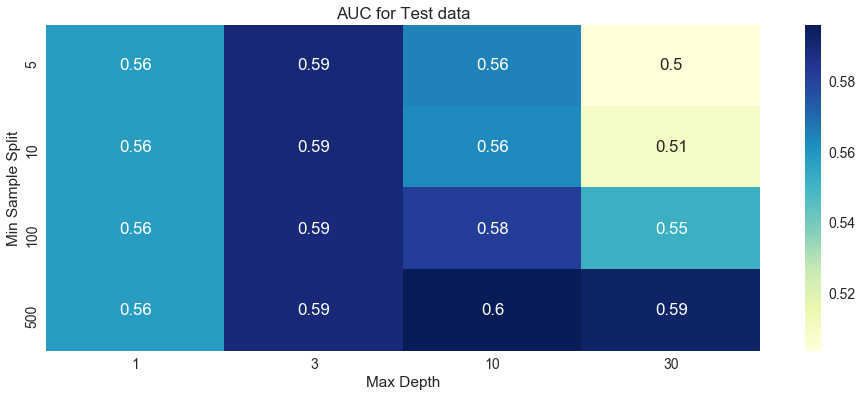

In [273]:
max_depth_list = list(classifier.cv_results_['param_max_depth'].data)
min_samples_list = list(classifier.cv_results_['param_min_samples_split'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(16,6))

data = pd.DataFrame(data={'Min Sample Split':min_samples_list, 'Max Depth':max_depth_list, 'AUC':classifier.cv_results_['mean_test_score']})
data = data.pivot(index='Min Sample Split', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Test data')
plt.show()

## Find the best parameters and fit the model.

In [274]:
best_min_samples_split = classifier.best_params_['min_samples_split']
best_max_depth_value = classifier.best_params_['max_depth']
best_score = classifier.best_score_

print("Value of best Min Samples are:",best_min_samples_split)
print("Value of best Max depth is:",best_max_depth_value)
print("Best Score is:",best_score)

Value of best Min Samples are: 500
Value of best Max depth is: 10
Best Score is: 0.5960111882558982


In [275]:
from sklearn.metrics import roc_curve, roc_auc_score

model = DecisionTreeClassifier(max_depth=best_max_depth_value, min_samples_split=best_min_samples_split,class_weight='balanced',random_state=0)
model.fit(X_train_tfidf_w2v,Y_train) 
# Used for task2 i.e. selecting k top features
best_features_index_tfidf=model.feature_importances_.argsort()[::-1]

## Plotting ROC-AUC curve

Training AUC Score: 0.7331841796264078
Test AUC Score: 0.5901846904207952


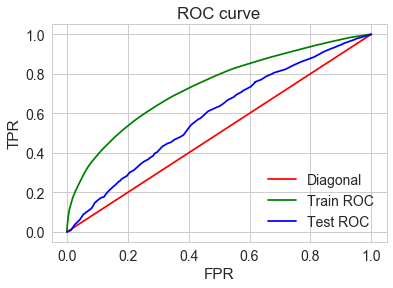

In [276]:
train_predictions = model.predict_proba(X_train_tfidf_w2v)
print("Training AUC Score:",roc_auc_score(Y_train, train_predictions[:,1]))

test_predictions = model.predict_proba(X_test_tfidf_w2v)
print("Test AUC Score:",roc_auc_score(Y_test, test_predictions[:,1]))

fpr_train, tpr_train, train_threshold = roc_curve(Y_train, train_predictions[:,1])
fpr_test, tpr_test, test_threshold = roc_curve(Y_test, test_predictions[:,1])

plt.plot([0,1],[0,1],'r',label="Diagonal")
plt.plot(fpr_train, tpr_train,'g',label="Train ROC")
plt.plot(fpr_test, tpr_test,'b',label="Test ROC")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')
plt.show()

## Observations->
Training AUC Score: 0.7331841796264078 and Test AUC Score: 0.5901846904207952. Train AUC is less than that of previous one but this model's differnece in train and test AUC is less but still value is high. It is also a highly overfit model

## Plotting Confusion Matrix

Confusion matrix


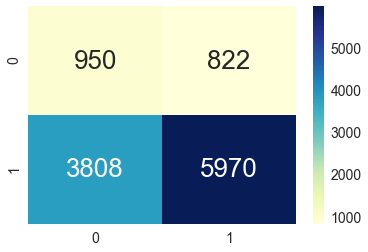

In [277]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix")
conf_matr_df_train = pd.DataFrame(confusion_matrix(Y_test, predict(test_predictions[:,1], test_threshold, fpr_test, tpr_test)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

<h1>3. Summary</h1>


In [278]:
from prettytable import PrettyTable
TB=PrettyTable()
TB.field_names=["Model","Hyper-Parameter","Train_AUC","Test_AUC"]
TB.add_row(["TF-IDF Model","Depth:10, sample-split:500","0.91","0.70"])
TB.add_row(["TF-IDF W2V Model","Depth:10, sample-split:500","0.73","0.59"])
print(TB)

+------------------+----------------------------+-----------+----------+
|      Model       |      Hyper-Parameter       | Train_AUC | Test_AUC |
+------------------+----------------------------+-----------+----------+
|   TF-IDF Model   | Depth:10, sample-split:500 |    0.91   |   0.70   |
| TF-IDF W2V Model | Depth:10, sample-split:500 |    0.73   |   0.59   |
+------------------+----------------------------+-----------+----------+
